## Machine Learning: bikeshare data for Capstone 1

The data can be found here, https://s3.amazonaws.com/capitalbikeshare-data/index.html.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from datetime import datetime as dt
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# define a function to read in each quarter of data
def read_bikeshare_data(year):
    dataframes = []
    for quarter in range(1, 5):
        dataframes.append(pd.read_csv(
            '../CapstoneDrafts/data/%dQ%d-capitalbikeshare-tripdata.csv' % (year, quarter), 
            parse_dates=True, index_col=1, header=0,
            names=['duration','enddate','startlocID','startloc','endlocID','endloc','bikeID','memtype']))
    return pd.concat(dataframes)

In [26]:
#read in the data
bike2015 = read_bikeshare_data(2015)
bike2016 = read_bikeshare_data(2016)

#### Modeling a time component

In [27]:
#add time tracking column (days from 1 January), break dates into month and day
def tidy_bike_df(df):
    df['startdate'] = df.index
    df['timeDelt'] = df['startdate'].apply(lambda d: (d - starttime).days)
    df['Year'] = df['startdate'].apply(lambda t: t.year)
    df['Month'] = df['startdate'].apply(lambda t: t.month)
    df['Day'] = df['startdate'].apply(lambda t: t.day)

In [31]:
starttime = dt.strptime('2015-01-01', '%Y-%m-%d')
tidy_bike_df(bike2015)

In [32]:
starttime = dt.strptime('2016-01-01', '%Y-%m-%d')
tidy_bike_df(bike2016)    

The 'timeDelt' column now ranges from 1 to 365 for all the days in 2016.  This will make it easier to model the progress of time through the year.  This dataframe also has the number of month, day, and year in separate columns so they are more accessible, just in case they are needed for later steps.

#### Merge 2015 and 2016 for the complete training dataset.

In [33]:
bike2015_2016 = bike2015.append(bike2016)

In [34]:
bike2015_2016.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6519900 entries, 2015-01-01 00:02:44 to 2016-12-31 23:54:20
Data columns (total 13 columns):
duration      int64
enddate       object
startlocID    int64
startloc      object
endlocID      int64
endloc        object
bikeID        object
memtype       object
startdate     datetime64[ns]
timeDelt      int64
Year          int64
Month         int64
Day           int64
dtypes: datetime64[ns](1), int64(7), object(5)
memory usage: 696.4+ MB


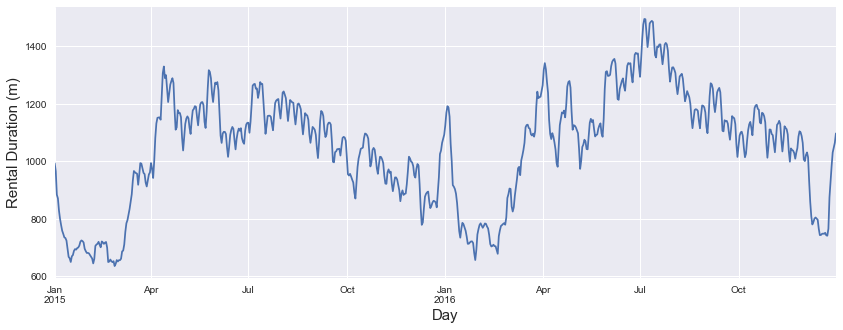

In [35]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(14,5)
duration = bike2015_2016['duration']
smoothed = duration.resample('D').mean().rolling(window=12, min_periods=1).mean()
smoothed.plot(ax=ax)
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Rental Duration (m)',fontsize=15)

Are there different durations for registered versus casual members?

In [36]:
durationReg = bike2015_2016['duration'][bike2015_2016['memtype']=='Member']
durationCas = bike2015_2016['duration'][bike2015_2016['memtype']=='Casual']

smoothedReg = durationReg.resample('D').mean().rolling(window=12, min_periods=1).mean()
smoothedCas = durationCas.resample('D').mean().rolling(window=12, min_periods=1).mean()

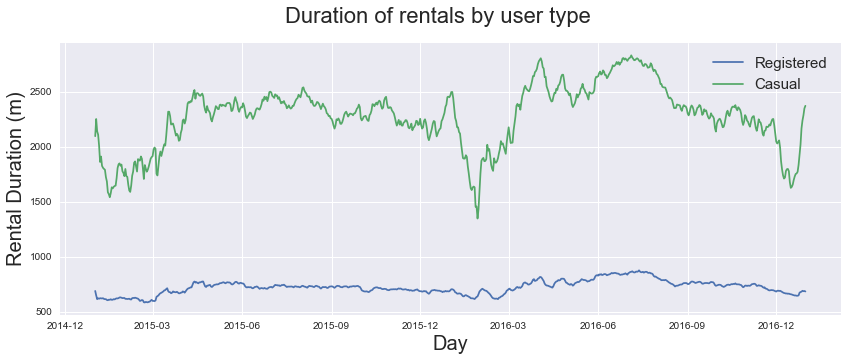

In [37]:
fig, ax = plt.subplots(1)
fig.set_size_inches(14,5)
ax.plot(smoothedReg, label='Registered')
ax.plot(smoothedCas, label='Casual')
ax.set_xlabel('Day',fontsize=20)
ax.set_ylabel('Rental Duration (m)',fontsize=20)
fig.suptitle('Duration of rentals by user type', fontsize=22)
ax.legend(fontsize=15)
#plt.savefig('bike_rolling_type',bbox_inches='tight',dpi=300)

In [38]:
bike2015_2016['startweekday'] = bike2015_2016['startdate'].apply(lambda d: d.weekday())

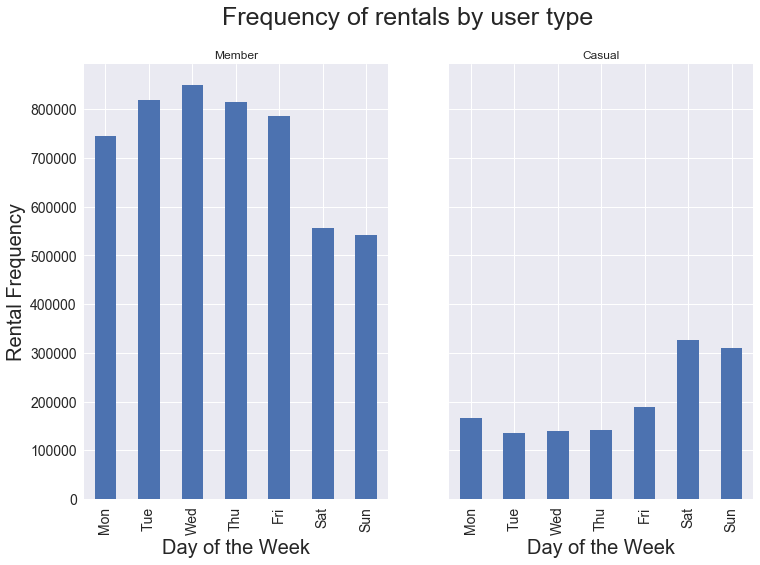

In [69]:
FreqReg=bike2015_2016['startweekday'][bike2015_2016['memtype']=='Member'].value_counts().sort_index()
FreqCas=bike2015_2016['startweekday'][bike2015_2016['memtype']=='Casual'].value_counts().sort_index()
ticks=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'] 
fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(12,8)
FreqReg.plot(kind='bar', ax=axes[0],title='Member',fontsize=14)
FreqCas.plot(kind='bar', ax=axes[1],title='Casual',fontsize=14)
axes[0].set_xticklabels(ticks)
axes[1].set_xticklabels(ticks)
fig.suptitle('Frequency of rentals by user type', fontsize=25)
axes[0].set_xlabel('Day of the Week',fontsize=20)
axes[0].set_ylabel('Rental Frequency',fontsize=20)
axes[1].set_xlabel('Day of the Week',fontsize=20)
#plt.savefig('bike_histo_type',bbox='tight',dpi=300)

## Analysis Steps

- Predict demand (# of rentals) on a given day (e.g. for 2017) 
    - linear regression/SVM
    - X: julian day; y: count/day
    - could add X: daily max temp, daily min temp, proximity to metro station
- Predict demand on a given day by station ID
    - linear regression/SVM
    - X: julian day, staion ID; y: count/day/station
    - coul add X: daily max temp, daily min temp, proximity to metro station


#### DC Metro Stations

In [70]:
#find metro station info (euclidian distance... find lat/long of metro stations)
import json
from pandas.io.json import json_normalize

json_data=open('../CapstoneDrafts/data/stations2.json').read()
metro=pd.read_json(json_data, orient='records')
MetroDF = json_normalize(data=metro['Stations'])

print('Number of stations:',len(MetroDF))
MetroDF.head()

Number of stations: 95


Address.City Address.State              Address.Street Address.Zip Code  \
0   Washington            DC             607 13th St. NW       20005  A01   
1   Washington            DC  1001 Connecticut Avenue NW       20036  A02   
2   Washington            DC            1525 20th St. NW       20036  A03   
3   Washington            DC   2700 Connecticut Ave., NW       20008  A04   
4   Washington            DC  3599 Connecticut Avenue NW       20008  A05   

         Lat LineCode1 LineCode2 LineCode3 LineCode4        Lon  \
0  38.898303        RD      None      None      None -77.028099   
1  38.903192        RD      None      None      None -77.039766   
2  38.909499        RD      None      None      None -77.043620   
3  38.924999        RD      None      None      None -77.052648   
4  38.934703        RD      None      None      None -77.058226   

                            Name StationTogether1 StationTogether2  
0                   Metro Center              C01                   
1                 Farragut North                                    
2                  Dupont Circle                                    
3  Woodley Park-Zoo/Adams Morgan                                    
4                 Cleveland Park

This table contains all of the metro station information for DC. I won't include it in the analysis, but will leave it here in case it helps with interpretation later.

#### Weather

In [48]:
# find and add weather data (daily max & min)
weather = pd.read_csv('../CapstoneDrafts/data/dc_weather_15_16.csv', parse_dates=True, index_col=1, header=0,
                        names=['station','startdate','precip','tmax','tmin'])
weather.head()

station  precip  tmax  tmin
startdate                                  
2015-01-01  USC00186350    0.00  36.0  22.0
2015-01-02  USC00186350    0.00  44.0  27.0
2015-01-03  USC00186350    0.07  47.0  29.0
2015-01-04  USC00186350    0.52  56.0  31.0
2015-01-05  USC00186350    0.08  66.0  40.0

In [72]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 726 entries, 2015-01-01 to 2016-12-31
Data columns (total 4 columns):
station    726 non-null object
precip     722 non-null float64
tmax       720 non-null float64
tmin       720 non-null float64
dtypes: float64(3), object(1)
memory usage: 28.4+ KB


These data are weather for 2016 in DC at the National Arboretum weather station. I gathered this data from NOAA's National Climate Data Center, Climate Data Online request form. Each row contains maximum and minimum temperatures for a day in 2016, in Farenheit.  

In [73]:
weather.describe()

precip        tmax        tmin
count  722.000000  720.000000  720.000000
mean     0.112022   68.930556   49.431944
std      0.298334   18.512655   18.054032
min      0.000000   19.000000    4.000000
25%      0.000000   54.000000   35.000000
50%      0.000000   71.000000   50.000000
75%      0.060000   85.000000   66.000000
max      2.850000   99.000000   81.000000

Temperatures in DC (at the National Arboretum) rance from 11-99 F in 2016.  Average high temperature is 69 F and average low temperature is 50 F. Average daily precipitation is .11", with 2.85" in one day being the maximum for the 2015-2016 period.

Temperature squared might be a better predictor, so let's also calculate that in the ```weather``` dataframe.

In [49]:
weather['tmax_sq'] = weather['tmax'].apply(lambda t: t**2)
weather['tmin_sq'] = weather['tmin'].apply(lambda t: t**2)

#### Daily totals

The next step is to total all the rental events for each day in 2016.  Let's first see what that might look like with a histogram using the 'timeDelt' column to summarize the data.

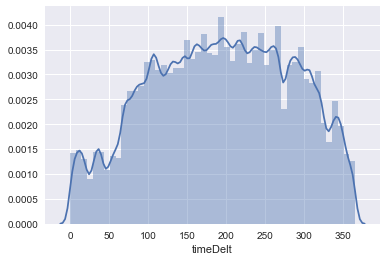

In [39]:
sns.distplot(bike2015_2016['timeDelt'])

It looks like the number of rentals is greatest from about day 75 through 325. This translates to March 15 through November 20.  One might guess this pattern correlates with weather, but let's keep moving.

In [40]:
grouped = bike2015_2016.groupby(['Year','timeDelt'])['Year','Month','Day','startdate','timeDelt','startweekday'].max()
grouped['totalRents'] = bike2015_2016.groupby(['Year','timeDelt'])['timeDelt'].size()
grouped['timeDelt_sq'] = grouped['timeDelt'].apply(lambda s: s**2)
grouped.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 727 entries, (2015, 0) to (2016, 365)
Data columns (total 8 columns):
Year            727 non-null int64
Month           727 non-null int64
Day             727 non-null int64
startdate       727 non-null datetime64[ns]
timeDelt        727 non-null int64
startweekday    727 non-null int64
totalRents      727 non-null int64
timeDelt_sq     727 non-null int64
dtypes: datetime64[ns](1), int64(7)
memory usage: 50.6 KB


In [41]:
grouped['startdate'] = grouped['startdate'].apply(lambda s: s.date())

In [42]:
grouped.head()

Year  Month  Day   startdate  timeDelt  startweekday  \
Year timeDelt                                                         
2015 0         2015      1    1  2015-01-01         0             3   
     1         2015      1    2  2015-01-02         1             4   
     2         2015      1    3  2015-01-03         2             5   
     3         2015      1    4  2015-01-04         3             6   
     4         2015      1    5  2015-01-05         4             0   

               totalRents  timeDelt_sq  
Year timeDelt                           
2015 0               2578            0  
     1               5108            1  
     2               1703            4  
     3               3658            9  
     4               5222           16

I've also calculated a column as the square of 'timeDelt' which will roughly estimate the cyclical pattern in yearly use patterns. In order to make merging easier later, I've also changed the data type of the 'startdate' column.

#### Holidays

In [45]:
# add holiday indicator
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2015-01-01','2016-12-31')
holidays

DatetimeIndex(['2015-01-01', '2015-01-19', '2015-02-16', '2015-05-25',
               '2015-07-03', '2015-09-07', '2015-10-12', '2015-11-11',
               '2015-11-26', '2015-12-25', '2016-01-01', '2016-01-18',
               '2016-02-15', '2016-05-30', '2016-07-04', '2016-09-05',
               '2016-10-10', '2016-11-11', '2016-11-24', '2016-12-26'],
              dtype='datetime64[ns]', freq=None)

In [46]:
series=pd.DataFrame(pd.Series(1, index=holidays, name='holiday'))
series['date']=series.index
series

holiday       date
2015-01-01        1 2015-01-01
2015-01-19        1 2015-01-19
2015-02-16        1 2015-02-16
2015-05-25        1 2015-05-25
2015-07-03        1 2015-07-03
2015-09-07        1 2015-09-07
2015-10-12        1 2015-10-12
2015-11-11        1 2015-11-11
2015-11-26        1 2015-11-26
2015-12-25        1 2015-12-25
2016-01-01        1 2016-01-01
2016-01-18        1 2016-01-18
2016-02-15        1 2016-02-15
2016-05-30        1 2016-05-30
2016-07-04        1 2016-07-04
2016-09-05        1 2016-09-05
2016-10-10        1 2016-10-10
2016-11-11        1 2016-11-11
2016-11-24        1 2016-11-24
2016-12-26        1 2016-12-26

In [47]:
grouped = pd.merge(grouped, series, left_on='startdate', right_on='date',how='left')
grouped['holiday'].fillna(0, inplace=True)

In [136]:
grouped.head()

Year  Month  Day   startdate  timeDelt  startweekday  totalRents  \
0  2015      1    1  2015-01-01         0             3        2578   
1  2015      1    2  2015-01-02         1             4        5108   
2  2015      1    3  2015-01-03         2             5        1703   
3  2015      1    4  2015-01-04         3             6        3658   
4  2015      1    5  2015-01-05         4             0        5222   

   timeDelt_sq  holiday date  
0            0      0.0  NaT  
1            1      0.0  NaT  
2            4      0.0  NaT  
3            9      0.0  NaT  
4           16      0.0  NaT

#### Combine data into a common dataframe.

In [ ]:
#merge weather data

In [50]:
weather['startdate2'] = weather.index
weather['startdate2'] = weather['startdate2'].apply(lambda s: s.date())
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 726 entries, 2015-01-01 to 2016-12-31
Data columns (total 7 columns):
station       726 non-null object
precip        722 non-null float64
tmax          720 non-null float64
tmin          720 non-null float64
tmax_sq       720 non-null float64
tmin_sq       720 non-null float64
startdate2    726 non-null object
dtypes: float64(5), object(2)
memory usage: 45.4+ KB


In [51]:
totals = pd.merge(grouped, weather, how='left', left_on='startdate', right_on='startdate2')
totals.head()

Year  Month  Day   startdate  timeDelt  startweekday  totalRents  \
0  2015      1    1  2015-01-01         0             3        2578   
1  2015      1    2  2015-01-02         1             4        5108   
2  2015      1    3  2015-01-03         2             5        1703   
3  2015      1    4  2015-01-04         3             6        3658   
4  2015      1    5  2015-01-05         4             0        5222   

   timeDelt_sq  holiday date      station  precip  tmax  tmin  tmax_sq  \
0            0      0.0  NaT  USC00186350    0.00  36.0  22.0   1296.0   
1            1      0.0  NaT  USC00186350    0.00  44.0  27.0   1936.0   
2            4      0.0  NaT  USC00186350    0.07  47.0  29.0   2209.0   
3            9      0.0  NaT  USC00186350    0.52  56.0  31.0   3136.0   
4           16      0.0  NaT  USC00186350    0.08  66.0  40.0   4356.0   

   tmin_sq  startdate2  
0    484.0  2015-01-01  
1    729.0  2015-01-02  
2    841.0  2015-01-03  
3    961.0  2015-01-04  
4   1600.0  2015-01-05

In [139]:
totals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 0 to 726
Data columns (total 17 columns):
Year            727 non-null int64
Month           727 non-null int64
Day             727 non-null int64
startdate       727 non-null object
timeDelt        727 non-null int64
startweekday    727 non-null int64
totalRents      727 non-null int64
timeDelt_sq     727 non-null int64
holiday         727 non-null float64
date            0 non-null datetime64[ns]
station         722 non-null object
precip          721 non-null float64
tmax            716 non-null float64
tmin            716 non-null float64
tmax_sq         716 non-null float64
tmin_sq         716 non-null float64
startdate2      722 non-null object
dtypes: datetime64[ns](1), float64(6), int64(7), object(3)
memory usage: 102.2+ KB


Some days have missing data, so let's forward fill those values.  Especially in the case of temperature data, a forward fill makes sense since one day's weather is more closely related to the day previous than the mean of the whole year.

In [52]:
totals=totals.fillna(method='ffill')

#### Categorical variables
We also need to create dummy variable columns for weekday.

In [53]:
# convert days of the week (startweekday) to dummy variable columns
weekday_dummies = pd.get_dummies(totals['startweekday'], prefix='day')
totals = pd.merge(totals, weekday_dummies, how='outer', left_index=True, right_index=True)

In [142]:
totals.head()

Year  Month  Day   startdate  timeDelt  startweekday  totalRents  \
0  2015      1    1  2015-01-01         0             3        2578   
1  2015      1    2  2015-01-02         1             4        5108   
2  2015      1    3  2015-01-03         2             5        1703   
3  2015      1    4  2015-01-04         3             6        3658   
4  2015      1    5  2015-01-05         4             0        5222   

   timeDelt_sq  holiday date  ...   tmax_sq  tmin_sq  startdate2  day_0  \
0            0      0.0  NaT  ...    1296.0    484.0  2015-01-01      0   
1            1      0.0  NaT  ...    1936.0    729.0  2015-01-02      0   
2            4      0.0  NaT  ...    2209.0    841.0  2015-01-03      0   
3            9      0.0  NaT  ...    3136.0    961.0  2015-01-04      0   
4           16      0.0  NaT  ...    4356.0   1600.0  2015-01-05      1   

   day_1  day_2 day_3  day_4  day_5  day_6  
0      0      0     1      0      0      0  
1      0      0     0      1      0      0  
2      0      0     0      0      1      0  
3      0      0     0      0      0      1  
4      0      0     0      0      0      0  

[5 rows x 24 columns]

In [143]:
totals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 727 entries, 0 to 726
Data columns (total 24 columns):
Year            727 non-null int64
Month           727 non-null int64
Day             727 non-null int64
startdate       727 non-null object
timeDelt        727 non-null int64
startweekday    727 non-null int64
totalRents      727 non-null int64
timeDelt_sq     727 non-null int64
holiday         727 non-null float64
date            0 non-null datetime64[ns]
station         727 non-null object
precip          727 non-null float64
tmax            727 non-null float64
tmin            727 non-null float64
tmax_sq         727 non-null float64
tmin_sq         727 non-null float64
startdate2      727 non-null object
day_0           727 non-null uint8
day_1           727 non-null uint8
day_2           727 non-null uint8
day_3           727 non-null uint8
day_4           727 non-null uint8
day_5           727 non-null uint8
day_6           727 non-null uint8
dtypes: datetime64[ns](1), float6

In [54]:
totals.to_csv('../CapstoneDrafts/data/2015_16totals.csv', index=False)

Model building continues in 'bikeshare_model' notebook.